# Seeing of Images
<font size="3">
    Here we check the seeing from the calibrated exposures done by the LSST Science Pipelines. This is a step prior to doing any photometry analysis.

In [43]:
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.table import QTable
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredDirectionArrows

In [39]:
dark_purple = '#2B018E'
lilac = '#ECE4FF'

<font size="3"> We can check the current collections available in the Butler repository!

In [3]:
butler = Butler('/home/jahumada/data_hits')
registry = butler.registry
for col in registry.queryCollections():
    print(col)

DECam/calib
DECam/calib/unbounded
DECam/calib/curated/19700101T000000Z
DECam/calib/curated/20130115T013000Z
DECam/calib/curated/20130916T092600Z
DECam/calib/curated/20140117T012900Z
DECam/calib/curated/20141020T103000Z
DECam/calib/curated/20150105T011500Z
DECam/calib/curated/20131130T000000Z
DECam/raw/all
DECam/raw/crosstalk-sources
DECam/raw/crosstalk-sources/20211008T204015Z
hits_master_calib/20150217_bias
hits_master_calib/20150217_bias/20211011T182910Z
hits_master_calib/20150217_flats
hits_master_calib/20150217_flats/20211011T194658Z
DECam/calib/20150217calibs
refcats
processCcdOutputs/20150217_calib
hits_master_calib/20150218_bias
hits_master_calib/20150218_bias/20211022T002123Z
hits_master_calib/on20150219_bias
hits_master_calib/on20150219_bias/20211022T015352Z
hits_master_calib/on20150220_bias
hits_master_calib/on20150220_bias/20211022T015436Z
hits_master_calib/on20150221_bias
hits_master_calib/on20150221_bias/20211022T015505Z
hits_master_calib/on20150219_bias/20211022T015834Z
h

<font size="3"> Here's the formula to calculate the seeing of each individual image. Because we are using DECam images, we can get the psf of the 59 operating ccds for every exposure. The output of this function is the average seeing of an exposure.

In [22]:
empiric_ccd_coords = pd.read_csv('empiric_ccd_coordinates.txt', names = ['ccd', 'x1', 'x2', 'y1', 'y2'], sep=' ')
empiric_ccd_coords['midx'] = (empiric_ccd_coords.x1 + empiric_ccd_coords.x2)/2
empiric_ccd_coords['midy'] = (empiric_ccd_coords.y1 + empiric_ccd_coords.y2)/2
detector_nomenclature= {'S29':1, 'S30':2, 'S31':3, 'S28':7, 'S27':6, 'S26':5, 'S25':4, 'S24':12, 'S23':11, 'S22':10, 'S21':9, 'S20':8, 'S19':18, 'S18':17, 'S17':16, 'S16':15, 'S15':14, 'S14':13, 'S13':24, 'S12':23, 'S11':22, 'S10':21, 'S9':20,'S8':19, 'S7':31, 'S6':30, 'S5':29, 'S4':28, 'S3':27, 'S2':26, 'S1':25, 'N29':60, 'N30':61, 'N31':62, 'N28':59, 'N27':58, 'N26':57, 'N25':56, 'N24':55, 'N23':54, 'N22':53, 'N21':52, 'N20':51, 'N19':50, 'N18':49, 'N17':48, 'N16':47, 'N15':46, 'N14':45, 'N13':44, 'N12':43, 'N11':42, 'N10':41, 'N9':40,'N8':39, 'N7':38, 'N6':37, 'N5':36, 'N4':35, 'N3':34, 'N2':33, 'N1':32 }


In [54]:
def checkSeeing(collection, visit, data_type, plot=False):
    """
    Calculates Seeing of individual exposure and ccd. 
    =====
    Input:
    =====
    collection: [string] name of the collection you want to look at.
    visit: [int] number of the visit, in my case this is equal to the exposure number.
    data_type: [string] name of the data type you want to analyze, in my case I want to see the 
                calibrated exposures, so this is equal to 'calexp'
    plot: [bool] Default False. If True, then it is plotted the calculated seeing for every detector.
    =====
    Output:
    =====
    avg_seeing: [float] average of the seeing for one exposure, it takes into account the operating ccds only
    see : [ndarray float] seeing for each detector
    """
    see = []
    seeaux = []
    cm = plt.cm.get_cmap('cool')
    
    detectors = [detector_nomenclature[d] for d in empiric_ccd_coords.ccd]#np.linspace(1,61,61)
    for i in detectors:
        try:
            calexp = butler.get(data_type, visit=visit, detector=int(i), collections=collection, instrument='DECam')
            sigma2fwhm = 2.*np.sqrt(2.*np.log(2.))
            psf = calexp.getPsf()
            arsec_to_pixel = 0.2626 #value from Manual of NOAO - DECam
            seeing = psf.computeShape(psf.getAveragePosition()).getDeterminantRadius()*sigma2fwhm * arsec_to_pixel
            see.append(seeing)
            seeaux.append(seeing)
        except:
            see.append(np.nan)
            
            pass
    
    
    avg_seeing=float('{0:.3g}'.format(np.mean(seeaux)))
    if plot:
        #plt.figure(figsize=(15,5))
        #plt.plot(detectors, see, 'm*')
        #plt.ylabel('Seeing', fontsize=17)
        #plt.xlabel('Detectors', fontsize=17)
        #plt.hlines(np.mean(seeaux),0, 61,color='r',linestyle='--', label='Average Seeing = {}'.format(avg_seeing))
        #plt.legend(frameon=False,fontsize=12 )
        #plt.xticks(detectors, rotation=20)
        #plt.xlim(1,61)
        #plt.show()
        fig, ax = plt.subplots(figsize=(10,10)) #plt.figure(figsize=(10,10))
        simple_arrow = AnchoredDirectionArrows(ax.transAxes, 'N', 'W')
        
        ax.add_artist(simple_arrow)
        sc = ax.scatter(empiric_ccd_coords.midx, empiric_ccd_coords.midy, c=see, vmin=min(seeaux), vmax=max(seeaux), s=200, cmap=cm, edgecolors=lilac)
        cbar = fig.colorbar(sc, label='Seeing')
        cbar.ax.set_ylabel('Seeing')
        ax.set_xlabel('degrees', fontsize=17)
        ax.set_ylabel('degrees', fontsize=17)
        for index, row in empiric_ccd_coords.iterrows():
            plt.text(row['midx'], row['midy'], row['ccd'], color=dark_purple, fontsize=15)
        #plt.legend(fontsize=17)
        plt.show()
    return avg_seeing, see

In [16]:
 np.linspace(1,61,61)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61.])

<font size="3"> This following cell retrieves all the exposures available in the butler repository. This makes it easy to locate all the exposures that compose a field that you want to do photometry on. 

In [5]:
exposures = []
data=pd.DataFrame(columns =['exposure','target_name', 'ra', 'dec', 'day_obs'])
for ref in registry.queryDimensionRecords('exposure',where="instrument='DECam' AND exposure.observation_type='science'"):
    exposures.append(ref.dataId['exposure'])
    new_row = {'exposure':ref.dataId['exposure'], 'target_name':ref.target_name, 'ra':ref.tracking_ra, 'dec':ref.tracking_dec, 'day_obs':ref.day_obs}
    data = data.append(new_row, ignore_index=True)
data

,exposure,target_name,ra,dec,day_obs
0,410934,Blind15A_45,156.856240,1.859948,20150217
1,411048,Blind15A_19,144.155110,-4.300884,20150217
2,410932,Blind15A_43,156.856239,-2.141079,20150217
3,410903,Blind15A_14,141.845110,-0.299801,20150217
4,410939,Blind15A_50,159.148285,-6.287440,20150217
...,...,...,...,...,...
1459,743294,Blind14A_39,173.696693,-2.096219,20180506
1460,743286,Blind14A_27,165.219744,-0.000468,20180506
1461,743397,Blind14A_36,171.276652,2.095420,20180507
1462,743297,Blind14A_25,165.226118,-4.192051,20180506


<font size="3"> Because I want to see the seeing for the field called "Blind15A_02", I can retrieve the exposures of that field, as well as it's coordinates in RA, DEC and observation date.

In [5]:
data[data['target_name']=='Blind15A_02']

,exposure,target_name,ra,dec,day_obs
60,410891,Blind15A_02,137.225152,-4.300827,20150217
138,410947,Blind15A_02,137.225110,-4.300883,20150217
151,410997,Blind15A_02,137.225035,-4.300883,20150217
225,411432,Blind15A_02,137.225035,-4.300911,20150218
238,411231,Blind15A_02,137.225198,-4.300827,20150218
270,411281,Blind15A_02,137.225077,-4.300856,20150218
300,411331,Blind15A_02,137.225152,-4.300856,20150218
309,411381,Blind15A_02,137.225077,-4.300883,20150218
400,411633,Blind15A_02,137.225110,-4.300827,20150219
441,411784,Blind15A_02,137.225035,-4.300911,20150219


In [27]:
def ObsDay(od):
    """
    This function only converts an array of dates in a format yearmonthday to day/month/year
    =====
    Input:
    =====
    od : [array of ints] observation dates in format yearmonthday
    ======
    Output:
    ======
    od_format : [array of strings] observation dates in format day/month/year
    """
    od_format = []
    for i in od:
        day = str(i)[6:]
        year = str(i)[0:4]
        month = str(i)[4:6]
        obsday = "{}/{}/{}".format(day,month,year)
        od_format.append(obsday)
    return od_format

<font size="3"> We can now calculate the average seeing for every exposure, and build a table. We have the option to plot the seeing of all detectors for every exposure, so we do that! hehe

In [ ]:
collection = 'processCcdOutputs/Blind15A_02'
visits = data[data['target_name']=='Blind15A_02'].exposure
OD = ObsDay(data[data['target_name']=='Blind15A_02'].day_obs)
avg_seeing = []
for i in visits:
    print('Visit: ',i)
    avg_seeing.append(checkSeeing(collection,i,'calexp', plot=True)[0])

t = QTable([visits, avg_seeing*u.arcsec, OD],
            names=('exposure', 'average seeing', 'Obs. Day'),
            meta={'name': 'first table'})

In [5]:
np.zeros(shape=(12,7))

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [8]:
detector_nomenclature= {'S29':1, 'S30':2, 'S31':3, 'S28':7, 'S27':6, 'S26':5, 'S25':4, 'S24':12, 'S23':11, 'S22':10, 'S21':9, 'S20':8, 'S19':18, 'S18':17, 'S17':16, 'S16':15, 'S15':14, 'S14':13, 'S13':24, 'S12':23, 'S11':22, 'S10':21, 'S9':20,'S8':19, 'S7':31, 'S6':30, 'S5':29, 'S4':28, 'S3':27, 'S2':26, 'S1':25, 'N29':60, 'N30':61, 'N31':62, 'N28':59, 'N27':58, 'N26':57, 'N25':56, 'N24':55, 'N23':54, 'N22':53, 'N21':52, 'N20':51, 'N19':50, 'N18':49, 'N17':48, 'N16':47, 'N15':46, 'N14':45, 'N13':44, 'N12':43, 'N11':42, 'N10':41, 'N9':40,'N8':39, 'N7':38, 'N6':37, 'N5':36, 'N4':35, 'N3':34, 'N2':33, 'N1':32 }
ccds_DECam = np.array([[0., 0., 'S31', 'S30', 'S29', 0., 0.],
       [0., 0., 'S28', 'S27', 'S26', 'S25', 0.],
       [0., 'S24', 'S23', 'S22', 'S21', 'S20', 0.],
       [0., 'S19', 'S18', 'S17', 'S16', 'S15', 'S14'],
       [0., 'S13', 'S12', 'S11', 'S10', 'S9', 'S8'],
       ['S7', 'S6', 'S5', 'S4', 'S3', 'S2', 'S1'],
       ['N7', 'N6', 'N5', 'N4', 'N3', 'N2', 'N1'],
       [0., 'N13', 'N12', 'N11', 'N10', 'N9', 'N8'],
       [0., 'N19', 'N18', 'N17', 'N16', 'N15', 'N14'],
       [0., 'N24', 'N23', 'N22', 'N21', 'N20', 0.],
       [0., 0., 'N28', 'N27', 'N26', 'N25', 0.],
       [0., 0., 'N31', 'N30', 'N29', 0., 0.]])


In [9]:
ccds_DECam

array([['0.0', '0.0', 'S31', 'S30', 'S29', '0.0', '0.0'],
       ['0.0', '0.0', 'S28', 'S27', 'S26', 'S25', '0.0'],
       ['0.0', 'S24', 'S23', 'S22', 'S21', 'S20', '0.0'],
       ['0.0', 'S19', 'S18', 'S17', 'S16', 'S15', 'S14'],
       ['0.0', 'S13', 'S12', 'S11', 'S10', 'S9', 'S8'],
       ['S7', 'S6', 'S5', 'S4', 'S3', 'S2', 'S1'],
       ['N7', 'N6', 'N5', 'N4', 'N3', 'N2', 'N1'],
       ['0.0', 'N13', 'N12', 'N11', 'N10', 'N9', 'N8'],
       ['0.0', 'N19', 'N18', 'N17', 'N16', 'N15', 'N14'],
       ['0.0', 'N24', 'N23', 'N22', 'N21', 'N20', '0.0'],
       ['0.0', '0.0', 'N28', 'N27', 'N26', 'N25', '0.0'],
       ['0.0', '0.0', 'N31', 'N30', 'N29', '0.0', '0.0']], dtype='<U32')

In [16]:
data[data['target_name']=='Blind15A_16']

,exposure,target_name,ra,dec,day_obs
19,411011,Blind15A_16,145.310077,1.700699,20150217
35,410961,Blind15A_16,145.310035,1.700699,20150217
156,410905,Blind15A_16,145.310110,1.700672,20150217
204,411446,Blind15A_16,145.310110,1.700699,20150218
296,411396,Blind15A_16,145.310077,1.700644,20150218
311,411245,Blind15A_16,145.310152,1.700672,20150218
316,411295,Blind15A_16,145.310077,1.700644,20150218
338,411345,Blind15A_16,145.310152,1.700699,20150218
451,411647,Blind15A_16,145.309944,1.700672,20150219
461,411798,Blind15A_16,145.310110,1.700672,20150219


blabla

Visit:  411011


No handles with labels found to put in legend.


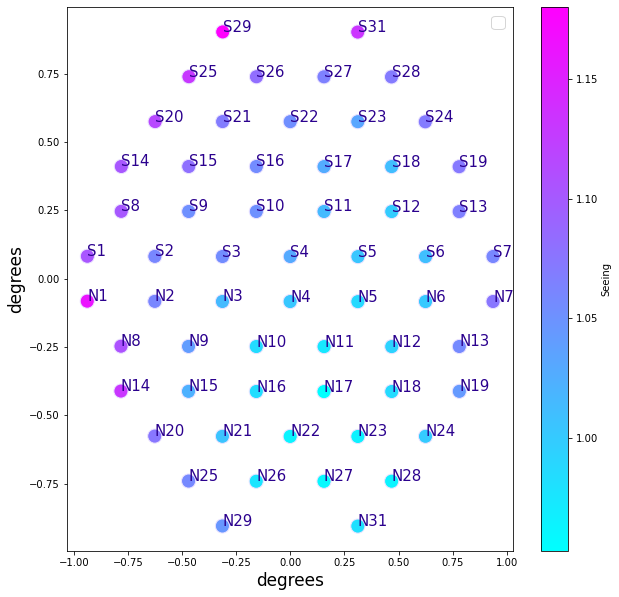

In [55]:
collection = 'processCcdOutputs/Blind15A_16'
visits = [data[data['target_name']=='Blind15A_16'].exposure.iloc[0]]
avg_seeing = []
for i in visits:
    print('Visit: ',i)
    avg_seeing.append(checkSeeing(collection,i,'calexp', plot=True)[0])

#t = QTable([visits, avg_seeing*u.arcsec, OD_v2],
#            names=('exposure', 'average seeing', 'Obs. Day'),
#            meta={'name': 'first table'})

In [9]:
data[data['target_name']=='Blind15A_16'].exposure.iloc[0]

411011

In [17]:
len(empiric_ccd_coords)

60

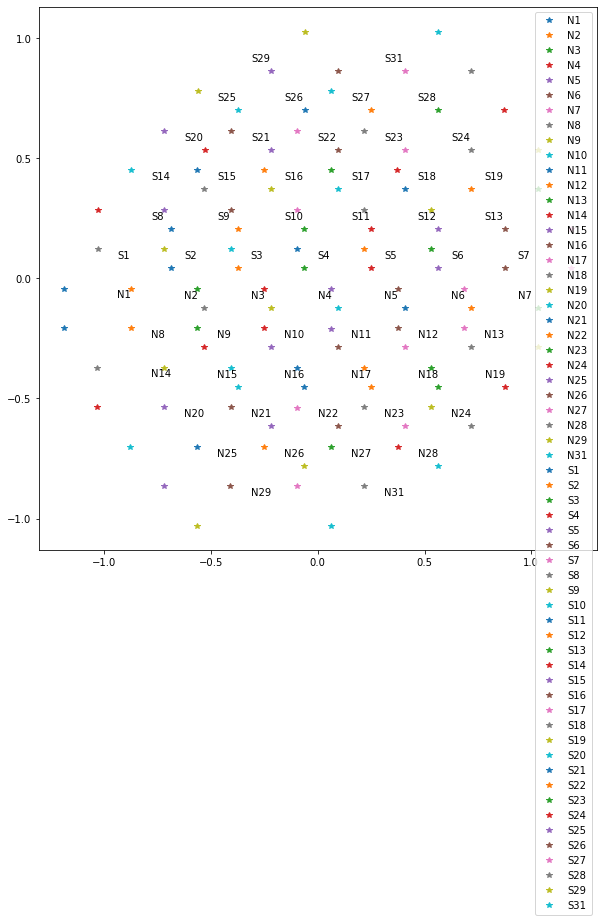

In [9]:
plt.figure(figsize=(10,10))

cm = plt.cm.get_cmap('cool')
xy = range(20)
z = xy
sc = plt.scatter(empiric_ccd_coords.midx, empiric_ccd_coords.midy, c=z, vmin=0, vmax=20, s=35, cmap=cm)
plt.colorbar(sc)
plt.show()
#for index, row in empiric_ccd_coords.iterrows():
#    plt.plot([row['x1'], row['x2']], [row['y1'], row['y2']],'*', label = row['ccd'])
#    midx = (row['x1']+ row['x2'])/2
#    midy = (row['y1']+ row['y2'])/2
#    row['midx'] = midx
#    row['midy'] = midy
#    plt.text(row['midx'], row['midy'], row['ccd'])
#plt.legend()

In [13]:
empiric_ccd_coords

,ccd,x1,x2,y1,y2,midx,midy
0,N1,-1.189983,-0.688523,-0.207399,0.043473,-0.939253,-0.081963
1,N2,-0.877679,-0.376066,-0.208000,0.042633,-0.626873,-0.082684
2,N3,-0.565582,-0.062781,-0.208337,0.041936,-0.314182,-0.083201
3,N4,-0.252719,0.250710,-0.208454,0.041554,-0.001005,-0.083450
4,N5,0.060670,0.563543,-0.208777,0.041410,0.312107,-0.083683
5,N6,0.374114,0.875558,-0.208467,0.041486,0.624836,-0.083490
6,N7,0.686722,1.187546,-0.208133,0.041671,0.937134,-0.083231
7,N8,-1.033837,-0.532637,-0.372105,-0.121524,-0.783237,-0.246815
8,N9,-0.721896,-0.219706,-0.372855,-0.122356,-0.470801,-0.247605
9,N10,-0.409201,0.094061,-0.373033,-0.122967,-0.157570,-0.248000
